# The pyshtools Class Interface

pyshtools defines three major classes that simplify access to the underlying SHTOOLS functions:

* **SHCoeffs:** Spherical harmonic coefficients
* **SHGrid:** Gridded data on the sphere
* **SHWindows:** Multitaper windowing functions

The underlying data are stored in internal subclasses in different formats (e.g. `kind = 'real'` or `'complex'` and `grid = 'DH'` or `'GLQ'`). In this tutorial, we will demonstrate several aspects related to the `SHCoeffs` and `SHGrid` classes.

## Plot a single spherical harmonic function

The spherical harmonic coefficient class `SHCoeffs` can be initialized directly from a numpy array that holds the spherical harmonic coefficient data. Spherical harmonic coefficients are stored as a numpy array of dimension (2, lmax+1, lmax+1), where the first column corresponds to the cosine [0] and sine [1] components, the second column
corresponds to the spherical harmonic degree `l`, and the third column corresponds to the angular order `m`. We will first create a numpy array of coefficients that are equal to zero, with the exception of the `l=5`, `m=2` harmonic.

In [1]:
%matplotlib inline
from __future__ import print_function # only necessary if using Python 2.x

import matplotlib.pyplot as plt
import numpy as np
from pyshtools.shclasses import SHCoeffs, SHGrid, SHWindow

lmax = 200
coeffs = np.zeros((2, lmax+1, lmax+1))
coeffs[0, 5, 2] = 1.

To initialize a new class instance, we make use of the constructor method `from_array()`:

In [2]:
coeffs_l5m2 = SHCoeffs.from_array(coeffs)

When initializing a new class instance, the default is to assume that the input coefficients are 4-pi normalized excluding the Condon-Shortley phase. This normalization convention can be overridden by setting the optional parameter 'normalization', which takes values of '4pi', 'ortho' or 'schmidt', along with the parameter 'csphase', which can be 1 (to exclude the Condon-Shortley phase) or -1 (to include it). The `SHCoeffs` class contains many methods, and here we use `plot_spectrum()` to plot the power spectrum: 

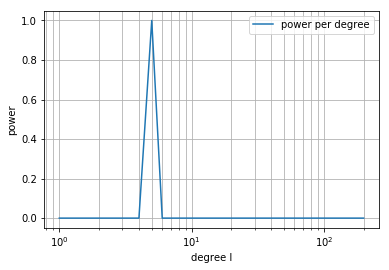

In [3]:
fig, ax = coeffs_l5m2.plot_spectrum(xscale='log', yscale='lin')

To plot the function that corresponds to the coefficients, we first need to expand it on a grid, which can be accomplished using the `expand()` method:

In [4]:
grid_l5m2 = coeffs_l5m2.expand('DH2')

This returns a new `SHGrid` class instance. The resolution of the grid is determined automatically to correspond to the maximum degree of the spherical harmonic coefficients in order to ensure good sampling. The optional parameter `'grid'` can be `'DH2'` for a Driscoll and Healy sampled grid with nlon = 2 * nlat, `'DH'` for a Driscol and Healy sampled grid with nlon = nlat, or `'GLQ'` for a grid used with the Gauss-Legendre quadrature expansion routines. Once the grid is created, it can be plotted using the built-in method `plot()`.

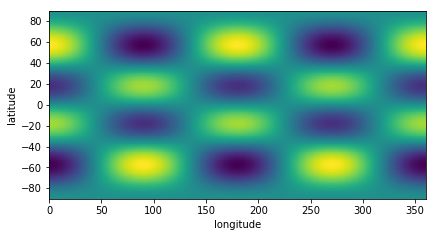

In [5]:
fig, ax = grid_l5m2.plot()

## Initialize with a random model

Another constructor for the `SHCoeffs` class is the `from_random()` method. It takes a power spectrum (power per degree l of the coefficients) and generates coefficients that are independent normal distributed random variables with the provided expected power spectrum. This corresponds to a stationary and isotropic random model on the surface of the sphere whose autocorrelation function is given by the spherical harmonic addition theorem.

We initialize coefficients here with a scale-free power spectrum that has equal band power beyond the scale length that defines the size of the largest model features. The particular property of this model is that it is invariant under zoom operations.

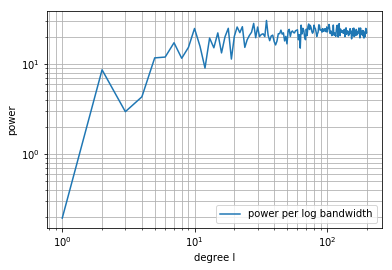

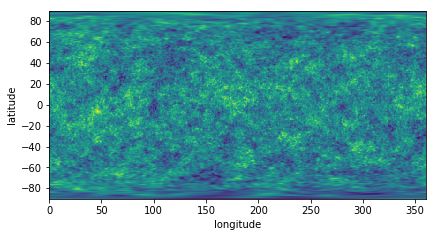

In [6]:
a = 10  # scale length
ls = np.arange(lmax+1, dtype=np.float)
power = 1. / (1. + (ls / a) ** 2) ** 0.5

coeffs_global = SHCoeffs.from_random(power)

fig, ax = coeffs_global.plot_spectrum(unit='per_dlogl', xscale='log')
fig, ax = coeffs_global.expand('DH2').plot()

## Rotating the coordinate system (or body)

Spherical harmonics coefficients can be expressed in a different coordinate system very efficiently. Importantly, the power per degree spectrum is invariant under rotation. 

The rotations are specified by the three Euler angles `alpha`, `beta`, and `gamma`. There are several different conventions for specifying these angles, and they can either provide the angles for rotating the physical body or coordinate system. Please read the documentation of this method carefully before proceeding! SHTOOLS uses the "y-convention" where the three angles correspond to (in this order):

* Rotation about the z axis by `alpha`,
* Rotation about the new y axis by `beta`,
* Rotation about the new z axis by `gamma`.

By using the angles `alpha`, `beta`, and `gamma` as is, the coordinate system will be rotated without rotation of the physical body. To instead rotate the physical body, and not the coordinate system, you would specify the angles `-gamma`, `-beta`, and `-alpha`. 

In this example, we use the constructor `from_zeros()`, and then use the method `set_coeffs()` to initialize a single zonal spherical harmonic coefficient. We then rotate this function that is centered about the north-pole to 30 degrees east longitude on the equator.

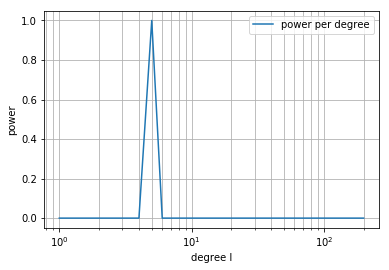

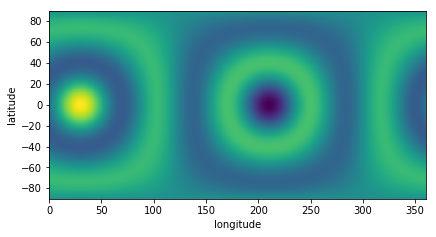

In [7]:
coeffs_l5m0 = SHCoeffs.from_zeros(lmax)
coeffs_l5m0.set_coeffs(1., 5, 0)

alpha = 30.  # rotation around the initial z-axis
beta = 90.  # rotation aroung the new y-axis
gamma = 0.  # rotation around the new z-axis

coeffs_l5m0_rot = coeffs_l5m0.rotate(-gamma, -beta, -alpha, degrees=True)

fig, ax = coeffs_l5m0_rot.plot_spectrum(xscale='log', yscale='lin', show=False)

grid_l5m0_rot = coeffs_l5m0_rot.expand('DH2')
fig, ax = grid_l5m0_rot.plot()

## Addition, multiplication, and subtraction

Similar grids can be added, multiplied and subtracted using standard python operators. It is easily verified that the following sequence of operations return the same rotated grid as above:

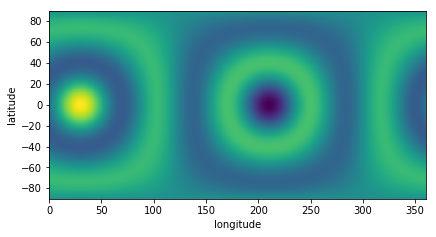

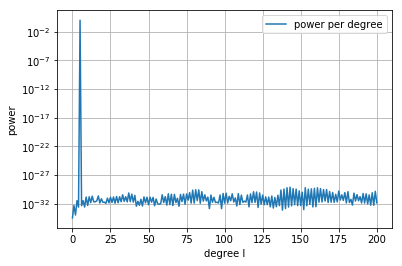

In [8]:
grid_new = (2 * grid_l5m0_rot + grid_l5m2**2 - grid_l5m2 * grid_l5m2) / 2.0
grid_new.plot()

coeffs = grid_new.expand()
fig, ax = coeffs.plot_spectrum()